# Validation croisée (cross-validation)

Il est acquis qu'un modèle doit être évalué sur une base de test différente de celle utilisée pour l'apprentissage. Mais la performance est peut-être juste l'effet d'une aubaine et d'un découpage particulièrement avantageux. Pour être sûr que le modèle est robuste, on recommence plusieurs fois. On appelle cela la validation croisée ou [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

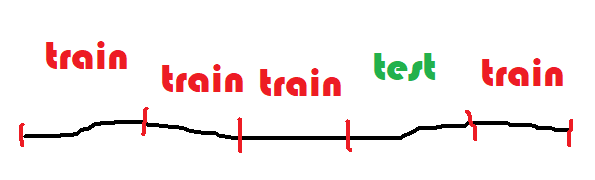

In [1]:
from pyquickhelper.helpgen import NbImage
NbImage('images/cross.png', width=300)

On découpe la base de données en cinq segments de façon aléatoire. On en utilise 4 pour l'apprentissage et 1 pour tester. On recommander 5 fois. Si le modèle est robuste, les cinq de scores de test seront sensiblement égaux.

In [2]:
%matplotlib inline

In [3]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


On utilise un modèle des plus proches voisins.

In [4]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)

Nous allons utiliser la fonction [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [5]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X, y, cv=5)

array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458])

Le score par défaut est $R^2$ :

In [6]:
from sklearn.metrics import make_scorer, r2_score
cross_val_score(knn, X, y, cv=5, scoring=make_scorer(r2_score))

array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458])

Si on souhaite utiliser score un autre score :

In [7]:
from sklearn.metrics import mean_squared_error
cross_val_score(knn, X, y, cv=5, scoring=make_scorer(mean_squared_error))

array([1.21615385, 1.21230769, 1.27328714, 1.14857583, 1.13702848])

Ou plusieurs à la fois :

In [8]:
from sklearn.model_selection import cross_validate
cross_validate(knn, X, y, cv=5, scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
              return_train_score=False)

{'fit_time': array([0.01061296, 0.01165581, 0.01012611, 0.01044178, 0.01029062]),
 'score_time': array([0.03170013, 0.02597094, 0.02496696, 0.02479029, 0.02687621]),
 'test_r2': array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458]),
 'test_e2': array([1.21615385, 1.21230769, 1.27328714, 1.14857583, 1.13702848])}

On obtient bien les mêmes résultats mais ils sont bien différents de ceux obtenus avec [train_est_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) et reproduits ci-dessous.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
r2_score(y_test, prediction)

-0.07846382920521244

Ca doit mettre la **puce à l'oreille**. De plus, étonnamment, le score $R^2$ est identique pour les tirages si on réexecute le code une seconde fois pour la validation croisée alors qu'il est différent pour une seconde répartition apprentissage test :

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
r2_score(y_test, prediction)

-0.08857016661350059

Les résultats sont rigoureusement identique pour la validation croisée.

In [11]:
cross_validate(knn, X, y, cv=5, scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
              return_train_score=False)

{'fit_time': array([0.01030278, 0.00798559, 0.00908589, 0.01347733, 0.01055026]),
 'score_time': array([0.01939273, 0.0261333 , 0.01949   , 0.02453303, 0.02227378]),
 'test_r2': array([-0.83897083, -0.4670711 , -0.59014921, -0.38119203, -0.77196458]),
 'test_e2': array([1.21615385, 1.21230769, 1.27328714, 1.14857583, 1.13702848])}

C'est quelque peu **suspect**, très suspect en fait, en statistique, c'est quasi miraculeux pour un nombre aussi volatile. Cela ne peut être dû au fait que la fonction fait exactement les mêmes découpages. Mettons un peu plus d'aléatoire :

In [12]:
from sklearn.model_selection import StratifiedKFold
from time import perf_counter 
res = cross_validate(knn, X, y,
               scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
               return_train_score=False, 
               cv=StratifiedKFold(n_splits=5, random_state=int(perf_counter ()*100), shuffle=True))
res

{'fit_time': array([0.0112462 , 0.01111269, 0.01031947, 0.00933695, 0.01353765]),
 'score_time': array([0.02112198, 0.02564454, 0.02541518, 0.025069  , 0.0216825 ]),
 'test_r2': array([-0.01118687, -0.00149193, -0.09720796,  0.01123596, -0.05408059]),
 'test_e2': array([0.7734255 , 0.76461538, 0.83769231, 0.75192604, 0.80107941])}

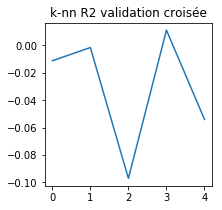

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(res['test_r2'])
ax.set_title('k-nn R2 validation croisée');

On retrouve les mêmes scores que pour [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Comment l'interpréter ? La raison la plus probable est que la validation croisée implémenté par *scikit-learn* n'est par défaut pas aléatoire. Cela explique qu'on retrouve les mêmes résultats sur deux exécutions. Il reste à expliquer le fait que les chiffres sont nettement mauvais pour le premier code et meilleur pour ce second code. 

**Et si les vins n'étaient pas mélangés dans la base avec des vins rouges au début et blancs vers la fin ?**

In [14]:
dfi = df.reset_index(drop=False)
import pandas
pandas.concat([dfi[['index', 'color']].head(), dfi[['index', 'color']].tail()])

,index,color
0,0,red
1,1,red
2,2,red
3,3,red
4,4,red
6492,6492,white
6493,6493,white
6494,6494,white
6495,6495,white
6496,6496,white


In [15]:
dfi[['index', 'color']].groupby('color').min()

,index
color,
red,0
white,1599


In [16]:
dfi[['index', 'color']].groupby('color').max()

,index
color,
red,1598
white,6496


Les éléments sont clairements triés par couleur et la validation croisée par défaut découpe selon cet ordre. Cela signifie presque que le modèle essaye de prédire la note d'un vin rouge en s'appuyant sur des vins blancs et cela ne marche visiblement pas. La validation croisée ne retourne pas de modèle mais cela peut être contourné avec [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [17]:
from sklearn.model_selection import GridSearchCV
cvgrid = GridSearchCV(estimator=knn, param_grid={}, fit_params=None,
               scoring=dict(r2=make_scorer(r2_score), e2=make_scorer(mean_squared_error)),
               return_train_score=False, refit='r2',
               cv=StratifiedKFold(n_splits=5, random_state=int(perf_counter ()*100), shuffle=True))

In [18]:
cvgrid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24726, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
       scoring={'r2': make_scorer(r2_score), 'e2': make_scorer(mean_squared_error)},
       verbose=0)

In [19]:
cvgrid.cv_results_

{'mean_fit_time': array([0.01427751]),
 'std_fit_time': array([0.0034482]),
 'mean_score_time': array([0.03225718]),
 'std_score_time': array([0.01047579]),
 'params': [{}],
 'split0_test_r2': array([-0.02926171]),
 'split1_test_r2': array([-0.03071051]),
 'split2_test_r2': array([0.01765128]),
 'split3_test_r2': array([-0.03840486]),
 'split4_test_r2': array([-0.10277728]),
 'mean_test_r2': array([-0.03666729]),
 'std_test_r2': array([0.03849103]),
 'rank_test_r2': array([1]),
 'split0_test_e2': array([0.78725038]),
 'split1_test_e2': array([0.78692308]),
 'split2_test_e2': array([0.75]),
 'split3_test_e2': array([0.78967643]),
 'split4_test_e2': array([0.8380879]),
 'mean_test_e2': array([0.79036478]),
 'std_test_e2': array([0.02801928]),
 'rank_test_e2': array([1])}

In [20]:
cvgrid.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')